In [1]:
import sys
import os
sys.path.append(os.path.dirname(sys.path[0]))
%load_ext autoreload
%autoreload 2
from uk_road_safety.python import analysis
import pygeohash as gh
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1979-2021.csv',sep=',')
df.head()

/tmp/ipykernel_30044/2129739407.py:1: DtypeWarning: Columns (0,2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1979-2021.csv',sep=',')


,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,197901A11AD14,1979,01A11AD14,NaN,NaN,NaN,NaN,1,3,2,...,-1,1,8,1,-1,0,-1,-1,-1,-1
1,197901A1BAW34,1979,01A1BAW34,198460.0,894000.0,NaN,NaN,1,3,1,...,-1,4,8,3,-1,0,-1,-1,-1,-1
2,197901A1BFD77,1979,01A1BFD77,406380.0,307000.0,NaN,NaN,1,3,2,...,-1,4,8,3,-1,0,-1,-1,-1,-1
3,197901A1BGC20,1979,01A1BGC20,281680.0,440000.0,NaN,NaN,1,3,2,...,-1,4,8,3,-1,0,-1,-1,-1,-1
4,197901A1BGF95,1979,01A1BGF95,153960.0,795000.0,NaN,NaN,1,2,2,...,-1,4,3,3,-1,0,-1,-1,-1,-1


In [3]:
df=df[df['accident_year']>=1999]

In [5]:
df.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021')

<AxesSubplot: xlabel='accident_severity', ylabel='Count'>

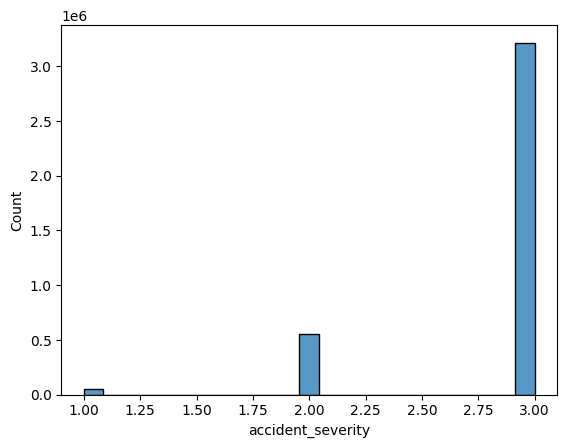

In [6]:
sns.histplot(data=df,x='accident_severity')

In [7]:
df['date']= pd.to_datetime(df['date'], format="%d/%m/%Y")

In [8]:
# slice first and second string from time column
df['Hour'] = df['time'].str[0:2]
# convert new column to numeric datetype
df['Hour'] = pd.to_numeric(df['Hour'])
# drop null values in our new column
df = df.dropna(subset=['Hour'])
# cast to integer values
df['Hour'] = df['Hour'].astype('int')

In [9]:
# define a function that turns the hours into daytime groups
def when_was_it(hour):
    if hour >= 5 and hour < 10:
        return "morning rush (5-10)"
    elif hour >= 10 and hour < 15:
        return "office hours (10-15)"
    elif hour >= 15 and hour < 19:
        return "afternoon rush (15-19)"
    elif hour >= 19 and hour < 23:
        return "evening (19-23)"
    else:
        return "night (23-5)"

In [10]:
# apply thus function to our temporary hour column
df['Daytime'] = df['Hour'].apply(when_was_it)

In [11]:
weekday_counts = pd.DataFrame(df.set_index('date').resample('1d')['accident_index'].size().reset_index())
weekday_counts.columns = ['Date', 'Count']
#weekday_counts

weekday = weekday_counts['Date'].dt.day_name()
#weekday

weekday_averages = pd.DataFrame(weekday_counts.groupby(weekday)['Count'].mean().reset_index())
weekday_averages.columns = ['Weekday', 'Average_Accidents']
weekday_averages.set_index('Weekday', inplace=True)
weekday_averages

,Average_Accidents
Weekday,
Friday,524.760200
Monday,453.759167
Saturday,429.460833
Sunday,352.233333
Thursday,478.625000
Tuesday,470.120000
Wednesday,474.516667


In [25]:
test = pd.DataFrame(df.set_index('date').resample('M').size())
test.columns = ['Accidents']
test

,Accidents
date,
1999-01-31,19457
1999-02-28,16432
1999-03-31,18870
1999-04-30,18483
1999-05-31,18620
1999-06-30,19422
1999-07-31,19924
1999-08-31,19344
1999-09-30,20836


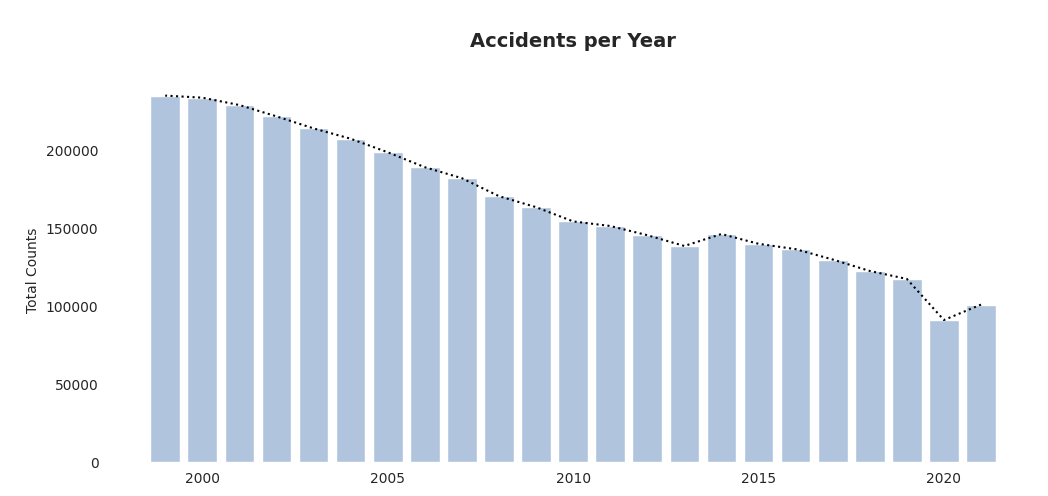

In [20]:

yearly_count = df['date'].dt.year.value_counts().sort_index(ascending=False)

# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,5))

# plot
ax.bar(yearly_count.index, yearly_count.values, color='lightsteelblue')
ax.plot(yearly_count, linestyle=':', color='black')
ax.set_title('\nAccidents per Year\n', fontsize=14, fontweight='bold')
ax.set(ylabel='\nTotal Counts')

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

In [21]:
fig.savefig('bars.png')

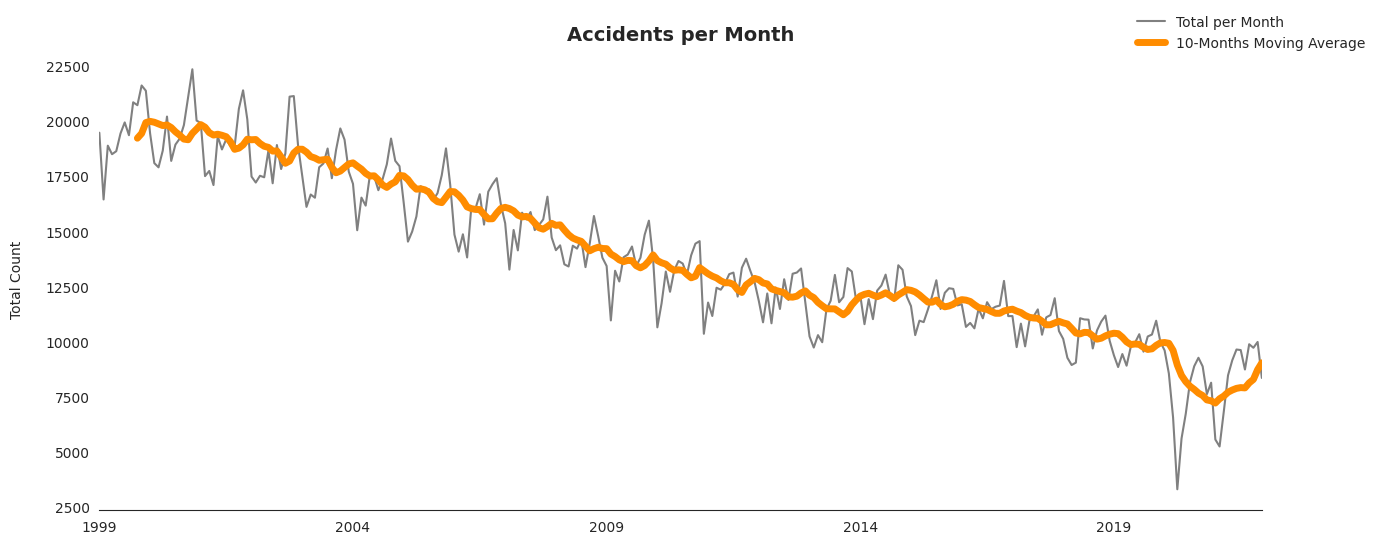

In [15]:
# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,6))

# plot
df.set_index('date').resample('M').size().plot(label='Total per Month', color='grey', ax=ax)
df.set_index('date').resample('M').size().rolling(window=10).mean()\
                           .plot(color='darkorange', linewidth=5, label='10-Months Moving Average', ax=ax)

ax.set_title('Accidents per Month', fontsize=14, fontweight='bold')
ax.set(ylabel='Total Count\n', xlabel='')
ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False)

# remove all spines
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False);

In [16]:
weekday = df['date'].dt.day_name()
year    = df['date'].dt.year

accident_table = df.groupby([year, weekday]).size()
accident_table = accident_table.rename_axis(['Year', 'Weekday'])\
                               .unstack('Weekday')\
                               #.reindex(columns=days)
accident_table

Weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Year,,,,,,,
1999,39268,33987,32077,25678,35365,34411,34262
2000,39104,33675,32613,25942,34953,33902,33540
2001,37539,33074,31734,25190,34304,33179,33994
2002,37744,32070,30261,24821,32723,31787,32345
2003,35872,31139,29295,24329,31400,30643,31352
2004,34536,28954,28299,22849,31555,30511,30706
2005,32738,27812,26945,21910,29738,29219,30373
2006,31994,26144,25980,21443,28150,27342,28108
2007,29262,26251,24686,20386,27303,26927,27300


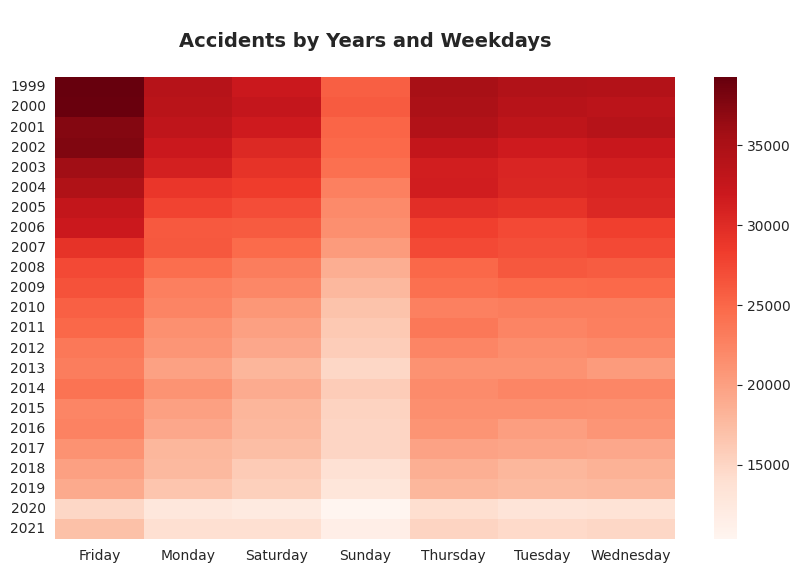

In [18]:
fig=plt.figure(figsize=(10,6))
sns.heatmap(accident_table, cmap='Reds')
plt.title('\nAccidents by Years and Weekdays\n', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('');

In [19]:
fig.savefig('heatmap.png')

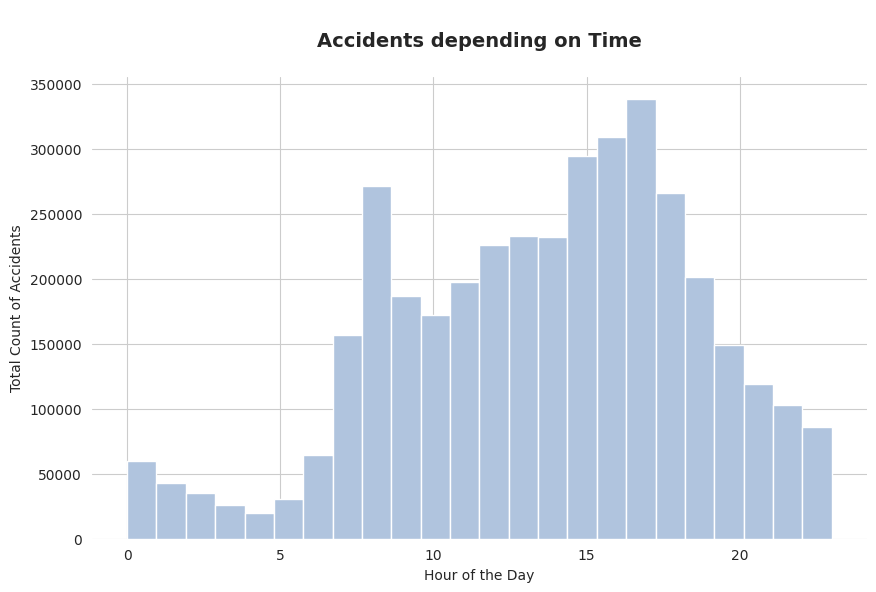

In [28]:
# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,6))

# plot
df.Hour.hist(bins=24, ax=ax, color='lightsteelblue')
ax.set_title('\nAccidents depending on Time\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Hour of the Day', ylabel='Total Count of Accidents')

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);

In [29]:
fig.savefig('time.png')

In [24]:
df.accident_severity.value_counts()

3    3214453
2     554908
1      51334
Name: accident_severity, dtype: int64

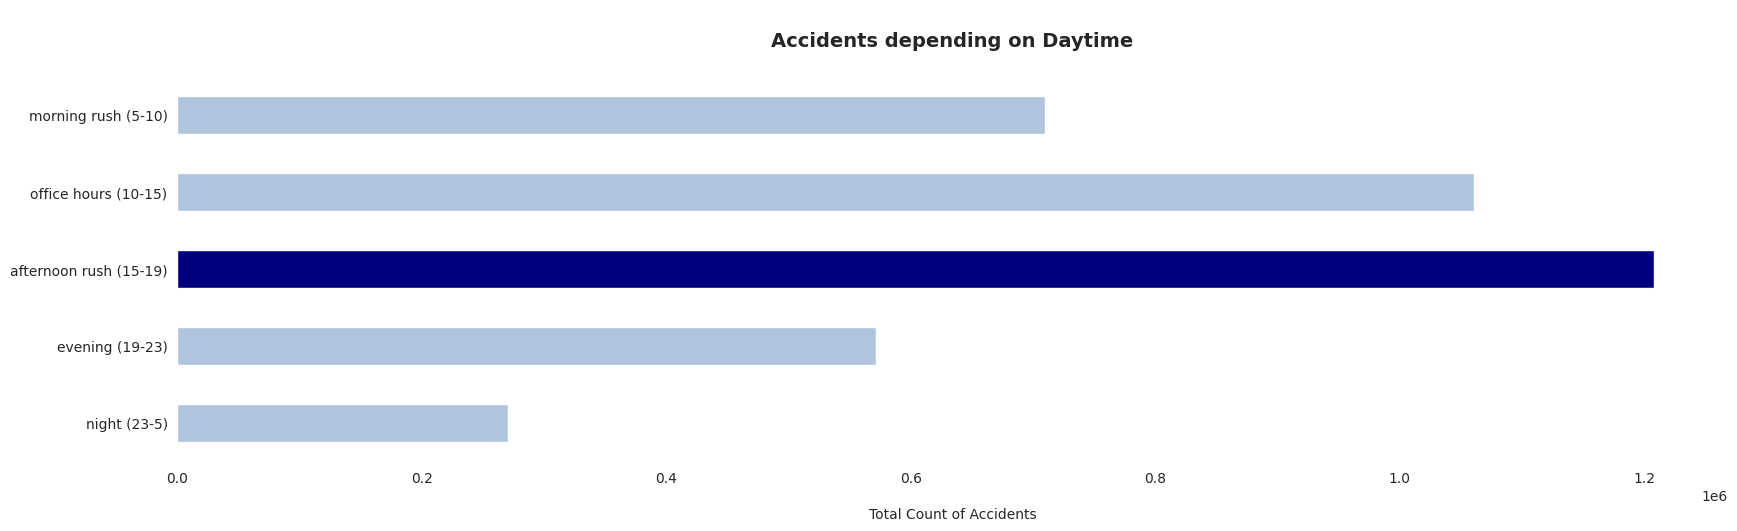

In [31]:
# prepare dataframe
order = ['night (23-5)', 'evening (19-23)', 'afternoon rush (15-19)', 'office hours (10-15)', 'morning rush (5-10)']
df_sub = df.groupby('Daytime').size().reindex(order)

# prepare barplot
fig, ax = plt.subplots(figsize=(20, 5))
colors = ['lightsteelblue', 'lightsteelblue', 'navy', 'lightsteelblue', 'lightsteelblue']

# plot
df_sub.plot(kind='barh', ax=ax, color=colors)
ax.set_title('\nAccidents depending on Daytime\n', fontsize=14, fontweight='bold')
ax.set(xlabel='\nTotal Count of Accidents', ylabel='')

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);

In [32]:
fig.savefig('windows.png')

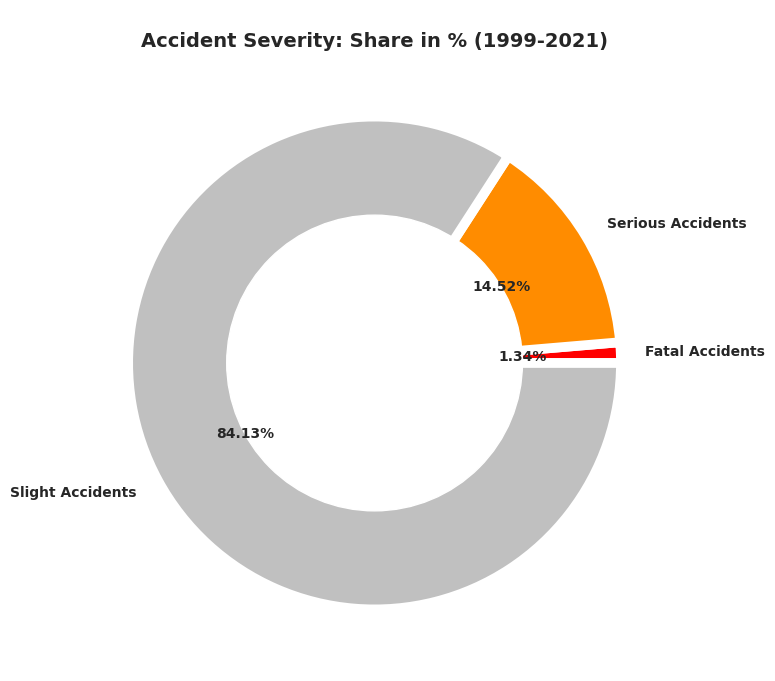

In [33]:
# assign the data
fatal   = df.accident_severity.value_counts()[1]
serious = df.accident_severity.value_counts()[2]
slight  = df.accident_severity.value_counts()[3]

names = ['Fatal Accidents','Serious Accidents', 'Slight Accidents']
size  = [fatal, serious, slight]
#explode = (0.2, 0, 0)

# create a pie chart
plt.pie(x=size, labels=names, colors=['red', 'darkorange', 'silver'], 
        autopct='%1.2f%%', pctdistance=0.6, textprops=dict(fontweight='bold'),
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(8,8)
fig.gca().add_artist(my_circle)
plt.title('\nAccident Severity: Share in % (1999-2021)', fontsize=14, fontweight='bold')
plt.show()


In [48]:
counts_share=df
counts_share['Fatal Accidents']=(df['accident_severity']==1).astype(int)
counts_share['Serious Accidents']=(df['accident_severity']==2).astype(int)
counts_share['Slight Accidents']=(df['accident_severity']==3).astype(int)

In [49]:
counts_share_grouped=counts_share[['Daytime','Fatal Accidents','Serious Accidents','Slight Accidents']].groupby('Daytime').sum()

In [50]:
counts_share_grouped

,Fatal Accidents,Serious Accidents,Slight Accidents
Daytime,,,
afternoon rush (15-19),12834,172887,1022041
evening (19-23),9719,93800,468358
morning rush (5-10),7887,92259,610063
night (23-5),8510,53888,207847
office hours (10-15),12384,142074,906144


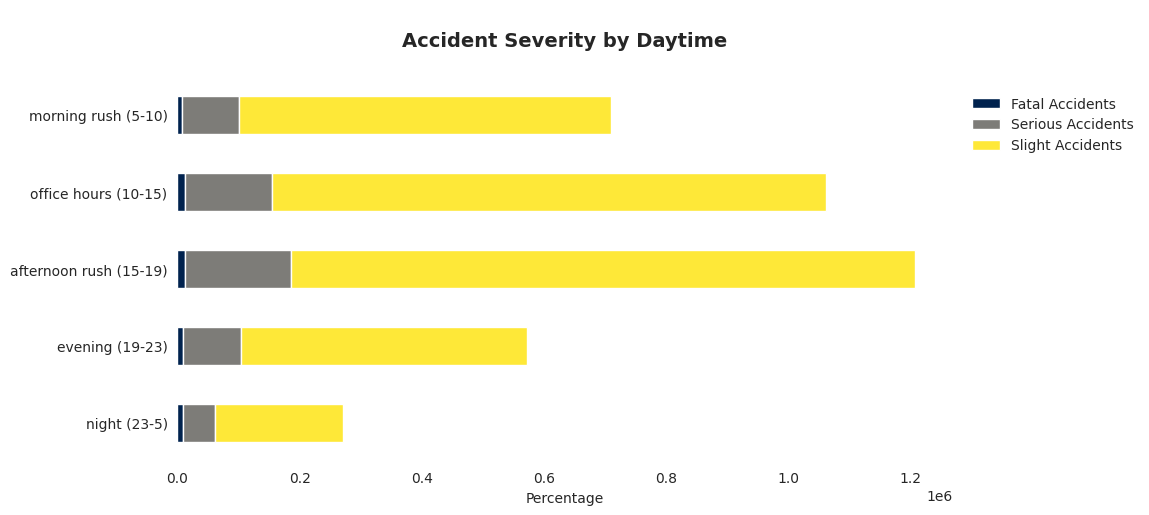

In [51]:
# prepare barplot
fig, ax = plt.subplots(figsize=(10, 5))

# plot
counts_share_grouped.reindex(order).plot(kind='barh', ax=ax, stacked=True, cmap='cividis')
ax.set_title('\nAccident Severity by Daytime\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Percentage', ylabel='')
ax.legend(bbox_to_anchor=(1.25, 0.98), frameon=False)

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);